In [1]:
#Import relevant libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import sklearn as sk
import sklearn.model_selection as ms
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from django.core.wsgi import get_wsgi_application
from matplotlib import pyplot as plt
import sys
sys.path.append(r'/home/sanjeev/models/ribbonsemble/ribbonsemble/scripts/')
sys.path.append(r'/home/sanjeev/models/ribbonsemble/ribbonsemble/')
sys.path.append(r'/home/sanjeev/models/ribbonsemble/ribbonsemble/hedonic_model/ml/utils/')
import load_properties as lp
import load_soldproperties as lsp
lp.setup_environment()
%matplotlib inline
import mplleaflet
import ast
import data_utils
import data_utils as du
from scipy.stats import norm, skew 

import properties...


In [2]:
#Create df of SoldProperties
#Base off this kernel: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
from hedonic_model.models import SoldProperty
#Data included: Built after 1900; at least 1BR and 1BATH; 
#Px btw 50k-2mm
from hedonic_model.models import ListProperty
from django_pandas.io import read_frame
pd.options.display.float_format = '{:.2f}'.format
qs = SoldProperty.objects.all()
df = read_frame(qs)
#Create test set and training set
df_train, df_test = ms.train_test_split(df,test_size=0.2)
print('size of training set: {} homes'.format(len(df_train)))
print('size of test set: {} homes'.format(len(df_test)))


size of training set: 1232 homes
size of test set: 308 homes


<b>PART 1: Exploratory Data Analysis</b>

<b> Part 1A: Features Summary, Expectations, Segmentation, Response Analysis, Comments </b>

Current Features:
* **zip_code** *Categorical* | Location | Medium | Zipcodes can overlap neighborhoods
* **latitude** *Numerical* | Location | High | Best representation of location  
* **longitude** *Numerical* | Location | High | Best representation of location
* **num_bedrooms** *Numerical* | Building | High | House size
* **num_bathrooms** *Numerical* | Building | High | House size
* **building_area_sq_ft** *Numerical* | Building | High | House size
* **home_type** *Numerical* | Building | Medium | Most will be explained with other vars
* **sale_price_history**: *Numerical* | Building | Medium | More useful in recent sales model, not hedonic
* **num_floors** *Numerical* | Building | Low | Data captured in other vars
* **rx_num_half_bath** *Numerical* | Building | Low | Data captured in other vars
* **rx_num_full_bath** *Numerical* | Building | Low | Data captured in other vars
* **year_built** *Numerical* | Building | Medium | Useful to find new builds which are worth more in general, and old properties that might have old age appeal
* **listing_status** *Categorical* | Location | Low | All these are sold; useless
* **flooring** *Categorical* | Quality | Medium | Better flooring will sell for more
* **interior_features** *Categorical* | Quality | Medium | Better interior features will sell for more
* **subdivision** *Categorical* | Location | Medium | Proxy for location/neighborhood
* **has_septic** *Categorical* | Quality | Low | Septic is worse, means it's rural
* **has_pool** *Categorical* | Quality | Medium | Pools might have a discount but a good proxy for neighborhood/location also
* **has_established_subdivision** *Categorical* | Location | Low | Is it in the middle of nowhere or not
* **has_well** *Categorical* | Quality | Medium | Better flooring will sell for more
* **has_garage** *Categorical* | Building | Medium | Garages are valued

* **garage_size** *Numerical* | Quality | Medium | Larger garages are more valued than smaller ones
* **description** *String* | Building/Quality | Medium | Need to parse this and engineer features to use this

Obvious Engineered Features:
* **sold_date** use history_to_last_sold_date (in data utils)
* **coordinates** turn latitude and longitude into coordinate pair
    * (NEIGHBORHOODS via K-Means clustering)
    * Distance from KEY POINTS (good schools etc)


Discarded: REASON
* **street_address_1**: redundant with lat/lon
* **street_address_2**: redundant with lat/lon
* **city**: all in charlotte
* **state**: all in north carolina
* **id**: arbitrary number 
* **hc_slug**: arbitrary text string
* **img_path_header**: arbitrary text string
* **img_paths_gallery**: arbitrary text string
* **local_school_quality**: disabled for now
* **remax_url**: arbitrary text string
* **red_bell_ave**: want this to be independent model
* **red_bell_ar_bpo**: want this to be independent model
* **red_bell_bpo**: want this to be independent model
* **certified_max_bid**: want this to be independent model
* **certified_max_bid_created_at**: want this to be independent model
* **house_canary_avm**: want this to be independent model
* **lowercase_slug**: arbitrary text string
* **no_pool_well_septic** combination of other features
* **is_foreclosure** false for all values

In [3]:
drop_cols = ['red_bell_ar_bpo','red_bell_bpo','certified_max_bid',
 'local_school_quality',
'certified_max_bid_created_at',
'house_canary_avm',
'red_bell_ave',
'is_foreclosure','img_path_header','img_paths_gallery','remax_url']
df_train = df_train.drop(drop_cols,axis=1)
df_test = df_test.drop(drop_cols,axis=1)

In [4]:
#Analyzing the Response/Target Variable: Sold Price
df_train['sold_price'].describe()
df_test['sold_price'].describe()

count       308.00
mean     472224.14
std      384193.45
min       55000.00
25%      219675.00
50%      352450.00
75%      549925.00
max     1999500.00
Name: sold_price, dtype: float64

In [5]:
df_train.columns

Index(['id', 'street_address_1', 'street_address_2', 'city', 'state',
       'zip_code', 'latitude', 'longitude', 'hc_slug', 'lowercase_slug',
       'sold_price', 'num_bedrooms', 'num_bathrooms', 'building_area_sq_ft',
       'home_type', 'sale_price_history', 'num_floors', 'rx_num_half_bath',
       'rx_num_full_bath', 'year_built', 'listing_status', 'flooring',
       'interior_features', 'subdivision', 'description', 'has_septic',
       'has_pool', 'has_established_subdivision', 'has_well', 'has_garage',
       'no_pool_well_septic', 'garage_size'],
      dtype='object')

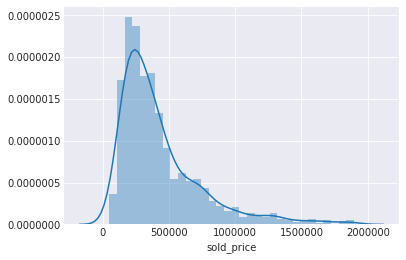

In [6]:
sns.distplot(df_train['sold_price'])

<b> We have learned that: </b>
* Sale price is not normally distributed
* Sale price has positive skewness (long right tail)
* Shows peakedness (distribution concentrated heavily in middle;
  skinny tails)

In [7]:
#Skewness and Kurtosis:
print('Skewness: {}'.format(df_train['sold_price'].skew()))
print('Kurtosis: {}'.format(df_train['sold_price'].kurt()))

Skewness: 1.8744475943489114
Kurtosis: 4.03609971505912


* Skew > 0 means *positively skewed*
* Kurtosis > 0 means *peakedness/skinny tails*

<b> Relationship of Sold Price to Expected high value  variables </b>:

<b>1. Building Area (Square Ft) </b>

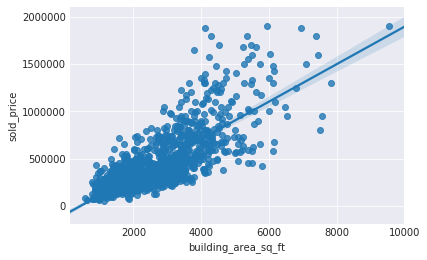

In [8]:
var = 'building_area_sq_ft'
ax = sns.regplot(x=var,y='sold_price',data=df_train)


A pretty clear linear relationship.  However, it seems heteroskedastic (ie, errors are not constant)

<b> 2. Num Bed and Baths </b>

Text(0.5,1,'charlotte: price distribution per num bedrooms')

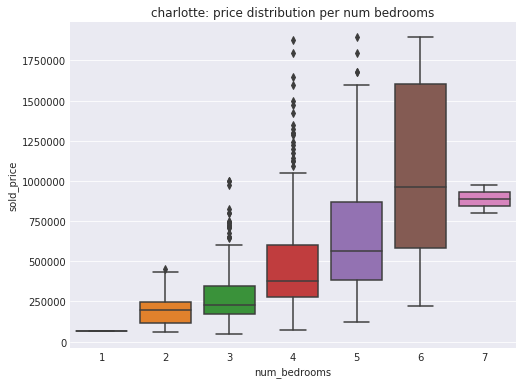

In [9]:
var = 'num_bedrooms'
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var,y='sold_price',data=df_train)
ax.set_title('charlotte: price distribution per num bedrooms')

Text(0.5,1,'charlotte: price distribution per num bathrooms')

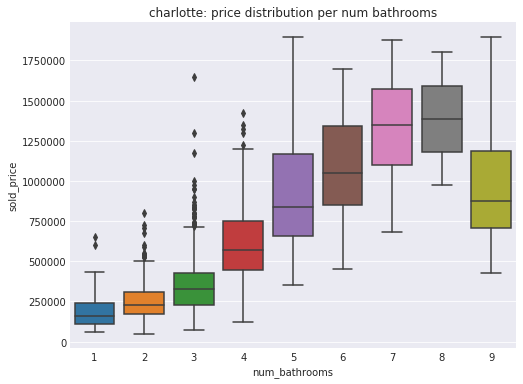

In [10]:
var = 'num_bathrooms'
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var,y='sold_price',data=df_train)
ax.set_title('charlotte: price distribution per num bathrooms')

Text(0.5,1,'price sold vs year built')

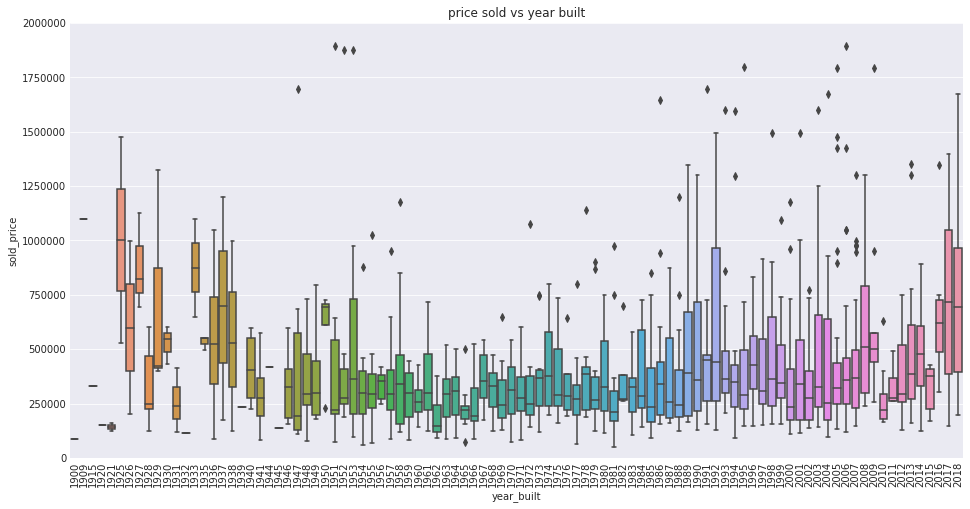

In [11]:
var = 'year_built'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="sold_price", data=df_train)
fig.axis(ymin=0, ymax=2000000)
plt.xticks(rotation=90)
ax.set_title('price sold vs year built')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

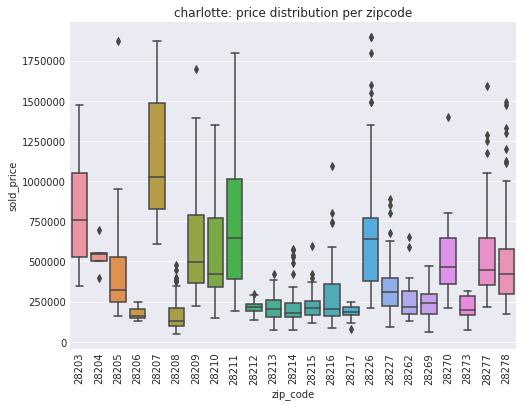

In [12]:
var = 'zip_code'
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=var,y='sold_price',data=df_train)
ax.set_title('charlotte: price distribution per zipcode')
plt.xticks(rotation=90)

<b> Conclusion: </b>

* Definitely found some important variables, but there are many more to explore

* We want to implement a combination of feature selection and feature engineering

* There are way more variables to explore, and have used intuition so far, so time to do a more objective, quantitative analysis:

<b> PART B: Objective analysis</b>

* Correlation matrix (heatmap)
* Sold Price correlation matrix
* Satterplots between most correlated variables

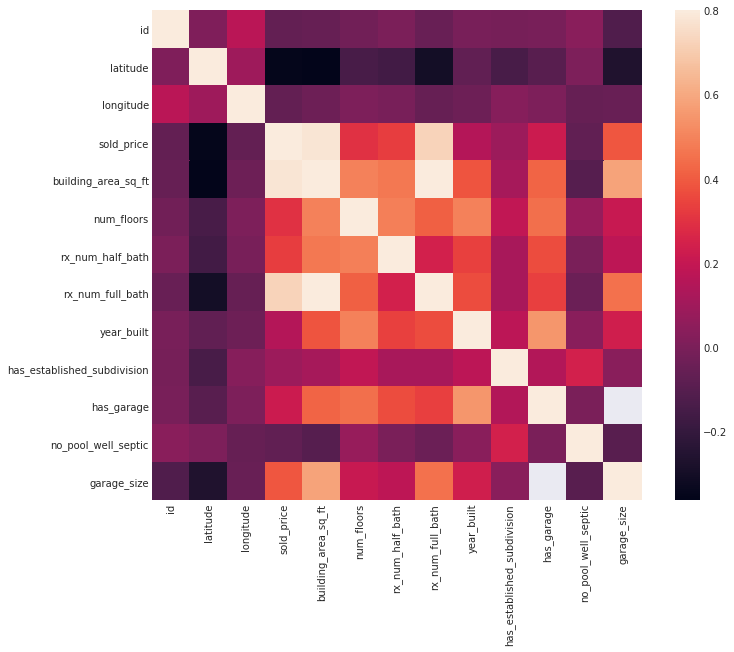

In [13]:
#Correlation matrix
corrmat = df_train.corr()
d, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.8,square=True)

**Conclusions:**

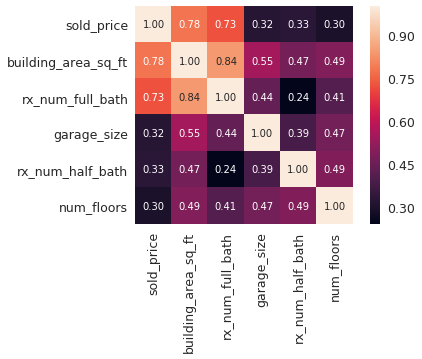

In [14]:
df_train = df_train[pd.notnull(df_train['building_area_sq_ft'])]
df_train = df_train[pd.notnull(df_train['num_floors'])]
df_train['garage_size']=df_train['garage_size'].fillna(0)
df_train['num_bedrooms']=df_train['num_bedrooms'].apply(lambda x: float(x))
df_train['num_bathrooms']=df_train['num_bathrooms'].apply(lambda x: float(x))
#saleprice correlation matrix
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sold_price')['sold_price'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


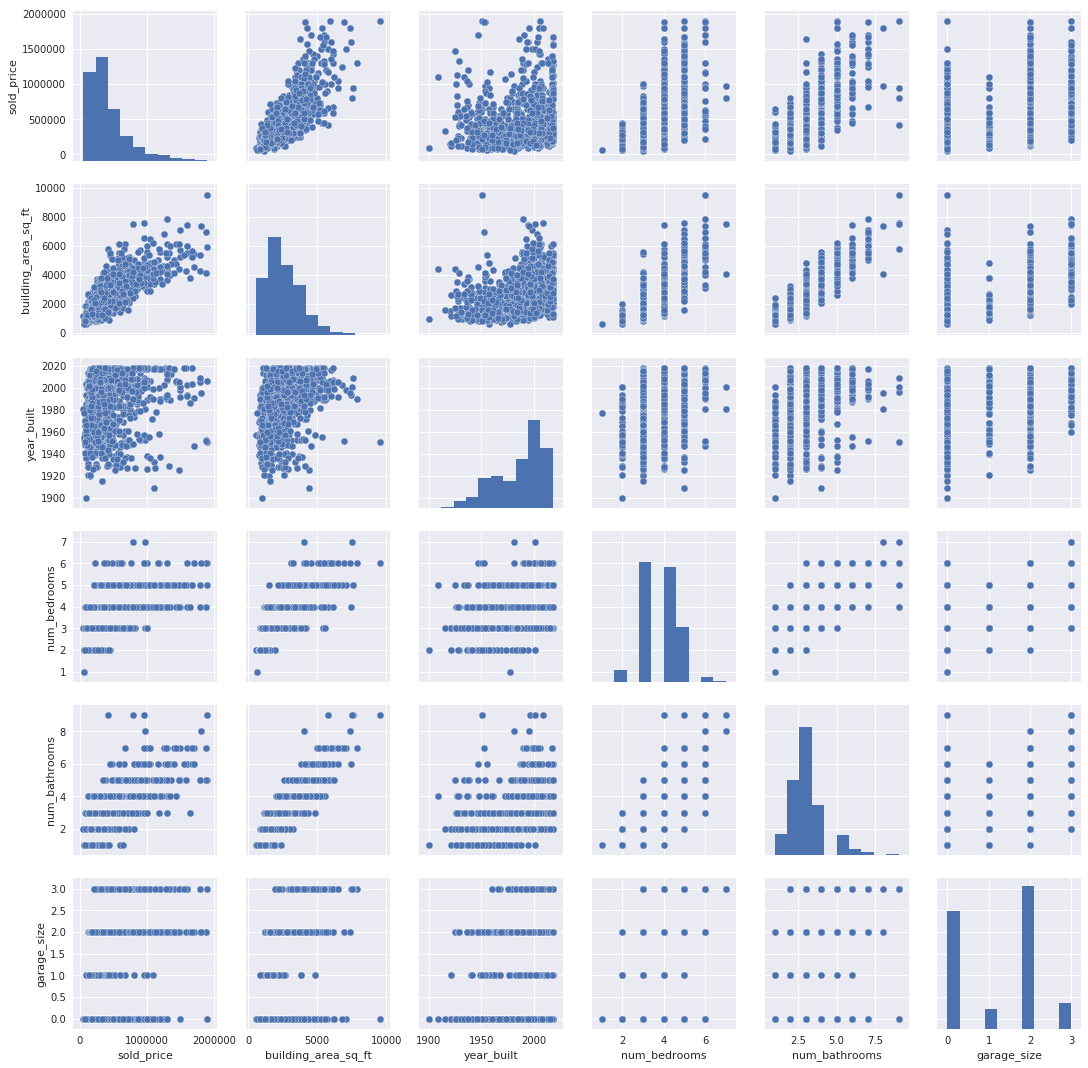

In [15]:
#scatterplot
sns.set()
cols = ['sold_price','building_area_sq_ft','year_built','num_bedrooms','num_bathrooms','garage_size']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

<b> PART C: MISSING DATA </b>

In [16]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
interior_features,285,0.23
flooring,108,0.09
subdivision,79,0.06
has_well,16,0.01
has_septic,16,0.01
has_pool,6,0.00
description,6,0.00
zip_code,0,0.00
lowercase_slug,0,0.00
hc_slug,0,0.00


In [17]:
df_train['interior_features'] = df_train['interior_features'].fillna('')
df_train['flooring'] = df_train['flooring'].fillna('')


In [18]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 0]).index,1)

In [19]:
#rechecking missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
garage_size,0,0.00
num_bedrooms,0,0.00
street_address_1,0,0.00
street_address_2,0,0.00
city,0,0.00
state,0,0.00
zip_code,0,0.00
latitude,0,0.00
longitude,0,0.00
hc_slug,0,0.00


<b> PART D: OUTLIERS </b>

In [20]:
#Univariate analysis
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['sold_price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.21394594]
 [-1.18203225]
 [-1.17246134]
 [-1.15043771]
 [-1.13448086]
 [-1.13416173]
 [-1.13416173]
 [-1.11852402]
 [-1.11820488]
 [-1.11182215]]

outer range (high) of the distribution:
[[ 3.97202783]
 [ 4.0358552 ]
 [ 4.0358552 ]
 [ 4.35499205]
 [ 4.35499205]
 [ 4.36775752]
 [ 4.61030153]
 [ 4.61030153]
 [ 4.6741289 ]
 [ 4.6741289 ]]


Low range values arent that far from zero...

High range values has some outliers.  The 3+ standard deviation results are worth being cautious about, but not worth removing right now

<b> PART E: Normalizing Response Variable  </b>

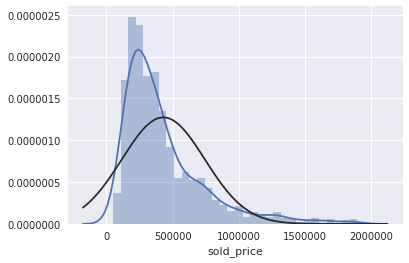

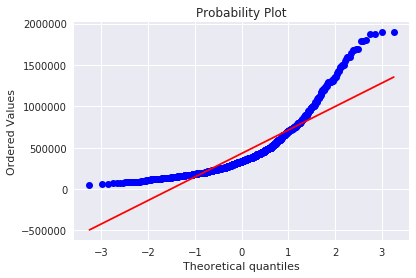

In [21]:
#histogram and normal probability plot
sns.distplot(df_train['sold_price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['sold_price'], plot=plt)

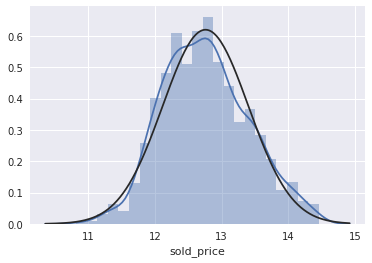

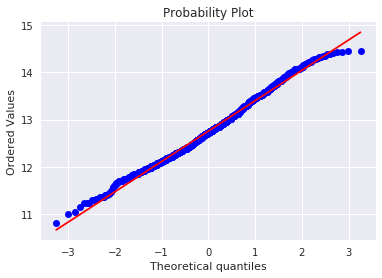

In [22]:
#applying log transformation
df_train['sold_price'] = np.log(df_train['sold_price'])
#transformed histogram and normal probability plot
sns.distplot(df_train['sold_price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['sold_price'], plot=plt)

<b> Conclusion: </b>

This normalizes the response variable so that it better approximates a normal distribution

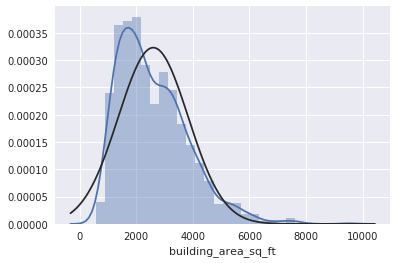

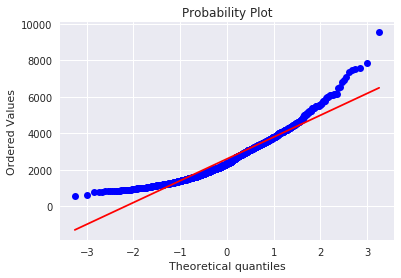

In [23]:
#histogram and normal probability plot
sns.distplot(df_train['building_area_sq_ft'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['building_area_sq_ft'], plot=plt)

In [24]:
df_train.columns

Index(['id', 'street_address_1', 'street_address_2', 'city', 'state',
       'zip_code', 'latitude', 'longitude', 'hc_slug', 'lowercase_slug',
       'sold_price', 'num_bedrooms', 'num_bathrooms', 'building_area_sq_ft',
       'home_type', 'sale_price_history', 'num_floors', 'rx_num_half_bath',
       'rx_num_full_bath', 'year_built', 'listing_status',
       'has_established_subdivision', 'has_garage', 'no_pool_well_septic',
       'garage_size'],
      dtype='object')

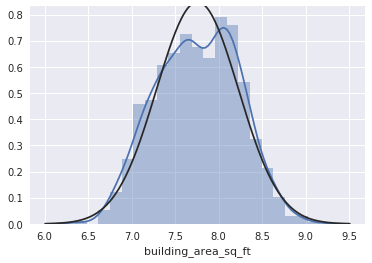

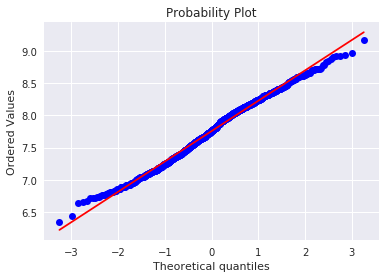

In [25]:
#applying log transformation
df_train['building_area_sq_ft'] = np.log(df_train['building_area_sq_ft'])
#transformed histogram and normal probability plot
sns.distplot(df_train['building_area_sq_ft'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['building_area_sq_ft'], plot=plt)

<b> PART II : Some Feature Engineering </b>

In [26]:
# Base off this script: https://www.kaggle.com/humananalog/xgboost-lasso

In [27]:
#Year and Month Sold are transformed into Categorical Features:

In [28]:
df_train['date_sold'] = df_train['sale_price_history'].apply(du.history_to_sold_date)
df_test['date_sold'] = df_test['sale_price_history'].apply(du.history_to_sold_date)

In [29]:
df_train = df_train[pd.notnull(df_train['date_sold'])]

df_train['year_sold'] = df_train['date_sold'].apply(lambda x: str(x.year))
df_train['month_sold'] = df_train['date_sold'].apply(lambda x: str(x.month))
df_test['year_sold'] = df_test['date_sold'].apply(lambda x: str(x.year))
df_test['month_sold'] = df_test['date_sold'].apply(lambda x: str(x.month))

In [30]:
#y_train = df_train['sold_price']
#df_train = df_train.drop(['sold_price'],axis=1)
df_train = df_train.drop(['date_sold'],axis=1)

In [31]:
y_train = df_train['sold_price']
df_train = df_train[['zip_code','num_bedrooms','num_bathrooms','building_area_sq_ft','year_sold','month_sold']]

In [32]:
#rechecking missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
month_sold,0,0.00
year_sold,0,0.00
building_area_sq_ft,0,0.00
num_bathrooms,0,0.00
num_bedrooms,0,0.00
zip_code,0,0.00


In [33]:
pd.get_dummies(df_train)

,num_bedrooms,num_bathrooms,building_area_sq_ft,zip_code_28203,zip_code_28204,zip_code_28205,zip_code_28206,zip_code_28207,zip_code_28208,zip_code_28209,...,month_sold_11,month_sold_12,month_sold_2,month_sold_3,month_sold_4,month_sold_5,month_sold_6,month_sold_7,month_sold_8,month_sold_9
549,4.00,4.00,8.02,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1089,4.00,4.00,8.24,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
442,3.00,3.00,7.58,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
729,2.00,1.00,6.64,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1445,4.00,4.00,8.21,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
432,3.00,2.00,7.67,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1209,3.00,3.00,7.51,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1140,5.00,7.00,8.52,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1520,4.00,4.00,8.19,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
654,3.00,3.00,7.21,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


<b>PART III: Modeling </b>

In [34]:
#Import libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Define a cross-validation strategy


In [35]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [36]:
#Define base models
#LASSO Regression
#NOTE This model may be very sensitive to outliers, to
#protect against this we use sklearn's Robustscaler method
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#Elastic Net Regression
#Again using the same technique to make it robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#XGBoost 
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [37]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3501 (0.0179)



In [38]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.3501 (0.0179)



In [39]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.3510 (0.0169)



In [40]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.2589 (0.0163)



In [41]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.2491 (0.0152)



In [42]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.2634 (0.0103)



<b> Part IV: Stacking/Ensembling </b>

In [43]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [44]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.3047 (0.0173)

